In [ ]:
%matplotlib inline


=======================================================================
Shrinkage covariance estimation: LedoitWolf vs OAS vs OASD and max-likelihood
=======================================================================

When working with covariance estimation, the usual approach is to use
a maximum likelihood estimator, such as the
:class:`sklearn.covariance.EmpiricalCovariance`. It is unbiased, i.e. it
converges to the true (population) covariance when given many
observations. However, it can also be beneficial to regularize it, in
order to reduce its variance; this, in turn, introduces some bias. This
example illustrates the simple regularization used in
`shrunk_covariance` estimators. In particular, it focuses on how to
set the amount of regularization, i.e. how to choose the bias-variance
trade-off.

Here we compare 3 approaches:

* Setting the parameter by cross-validating the likelihood on three folds
  according to a grid of potential shrinkage parameters.

* A close formula proposed by Ledoit and Wolf to compute
  the asymptotically optimal regularization parameter (minimizing a MSE
  criterion), yielding the :class:`sklearn.covariance.LedoitWolf`
  covariance estimate.

* An improvement of the Ledoit-Wolf shrinkage, the
  :class:`sklearn.covariance.OAS`, proposed by Chen et al. Its
  convergence is significantly better under the assumption that the data
  are Gaussian, in particular for small samples.

To quantify estimation error, we plot the likelihood of unseen data for
different values of the shrinkage parameter. We also show the choices by
cross-validation, or with the LedoitWolf and OAS estimates.

Note that the maximum likelihood estimate corresponds to no shrinkage,
and thus performs poorly. The Ledoit-Wolf estimate performs really well,
as it is close to the optimal and is computational not costly. In this
example, the OAS estimate is a bit further away. Interestingly, both
approaches outperform cross-validation, which is significantly most
computationally costly.




Automatically created module for IPython interactive environment


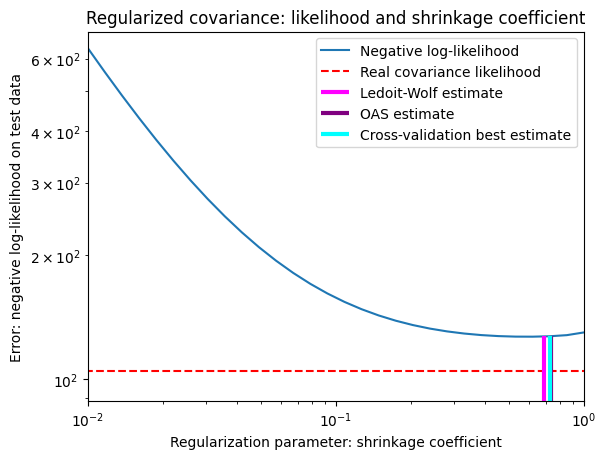

In [10]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, \
    log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV


# #############################################################################
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# #############################################################################
# Compute the likelihood on test data

# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model, which we would not have access to in real
# settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# #############################################################################
# Compare different approaches to setting the parameter

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{'shrinkage': shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# #############################################################################
# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
# range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], '--r',
         label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
# LW likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta',
           linewidth=3, label='Ledoit-Wolf estimate')
# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')
# best CV estimator likelihood
plt.vlines(cv.best_estimator_.shrinkage, ymin,
           -cv.best_estimator_.score(X_test), color='cyan',
           linewidth=3, label='Cross-validation best estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()

In [17]:
if sigma2_hat > sigma2 * 10:
    print("Warning: sigma2_hat is much larger than sigma2. The shrinkage estimate may be unreliable.")

In [18]:
shrinkage_osa = max(0.0, min(1.0, shrinkage_osa))

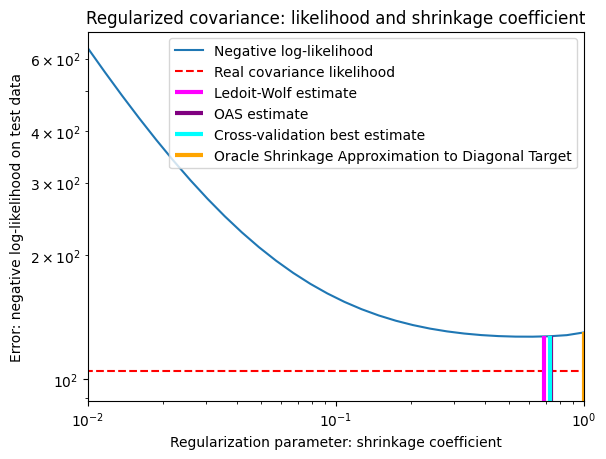

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the likelihood on test data
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, np.linalg.inv(real_cov))

# Compare different approaches to setting the parameter
tuned_parameters = [{'shrinkage': shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

alpha = 0.5 # Regularization parameter for OSA
sigma2 = np.trace(emp_cov) / n_features # Sample variance
sigma2_hat = np.trace(emp_cov @ emp_cov) / n_features # Trace of the squared sample covariance matrix
shrinkage_osa = min((sigma2_hat - sigma2) / (sigma2 - sigma2_hat / n_features), 1.0)
osa = ShrunkCovariance(shrinkage=shrinkage_osa)


# Oracle Shrinkage Approximation to Diagonal Target (OASD)
shrinkage_oasd = np.trace(emp_cov) / np.trace(np.diag(np.diag(emp_cov)))
oasd = ShrunkCovariance(shrinkage=shrinkage_oasd)
loglik_oasd = oasd.fit(X_train).score(X_test)

# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], '--r', label="Real covariance likelihood")

ymin = np.nanmin(negative_logliks) - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = np.nanmax(negative_logliks) + 10. * np.log(np.nanmax(negative_logliks) - np.nanmin(negative_logliks))
xmin = shrinkages[0]
xmax = shrinkages[-1]

plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta',
           linewidth=3, label='Ledoit-Wolf estimate')

plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')

plt.vlines(cv.best_estimator_.shrinkage, ymin,
           -cv.best_estimator_.score(X_test), color='cyan',
           linewidth=3, label='Cross-validation best estimate')



plt.vlines(shrinkage_oasd, ymin, -loglik_oasd, color='orange',
           linewidth=3, label='Oracle Shrinkage Approximation to Diagonal Target')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()


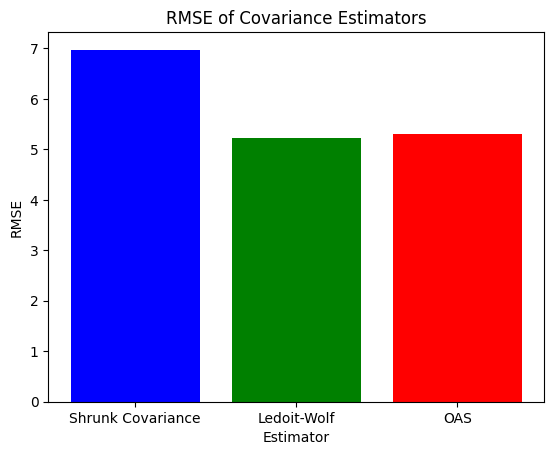

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)

# Compute RMSE for each estimator
def rmse(estimator):
    estimated_cov = estimator.covariance_
    return np.sqrt(np.mean((true_cov - estimated_cov) ** 2))

rmse_shrunk_cov = rmse(shrunk_cov)
rmse_lw = rmse(lw)
rmse_oa = rmse(oa)

# Plot results
estimators = ['Shrunk Covariance', 'Ledoit-Wolf', 'OAS']
rmse_values = [rmse_shrunk_cov, rmse_lw, rmse_oa]

plt.bar(estimators, rmse_values, color=['blue', 'green', 'red'])
plt.title('RMSE of Covariance Estimators')
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.show()


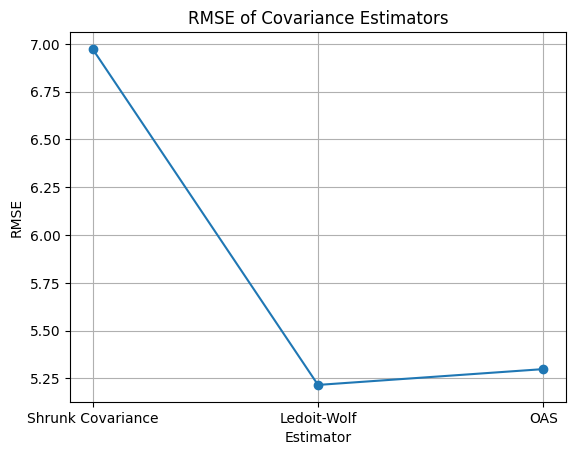

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)

# Compute RMSE for each estimator
def rmse(estimator):
    estimated_cov = estimator.covariance_
    return np.sqrt(np.mean((true_cov - estimated_cov) ** 2))

rmse_shrunk_cov = rmse(shrunk_cov)
rmse_lw = rmse(lw)
rmse_oa = rmse(oa)

# Plot results
estimators = ['Shrunk Covariance', 'Ledoit-Wolf', 'OAS']
rmse_values = [rmse_shrunk_cov, rmse_lw, rmse_oa]

plt.plot(estimators, rmse_values, marker='o', linestyle='-')
plt.title('RMSE of Covariance Estimators')
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


True Covariance:
[[ 55.98650342  10.78037447  -2.20052586 ... -11.80252269   1.88835878
    8.74131975]
 [ 10.78037447  47.38235643   1.41777213 ...   7.80899951  11.93443129
   -1.28672464]
 [ -2.20052586   1.41777213  35.06426316 ...  -9.23626087   3.77178661
   -0.3146597 ]
 ...
 [-11.80252269   7.80899951  -9.23626087 ...  46.81951921   9.72228333
    2.03238391]
 [  1.88835878  11.93443129   3.77178661 ...   9.72228333  43.0968695
    0.83461851]
 [  8.74131975  -1.28672464  -0.3146597  ...   2.03238391   0.83461851
   22.47597744]]
Shrunk Covariance:
[[ 44.83415459   7.7811139   -8.29053957 ...   3.67995136   3.21147403
   11.45340052]
 [  7.7811139   41.66909357  -1.1619159  ...   4.60414672  10.96417587
    8.6605628 ]
 [ -8.29053957  -1.1619159   29.01126628 ... -10.64880997  -4.11952508
   -1.89652291]
 ...
 [  3.67995136   4.60414672 -10.64880997 ...  63.55180808   2.74847418
   14.16160441]
 [  3.21147403  10.96417587  -4.11952508 ...   2.74847418  24.62226712
    2.4204743

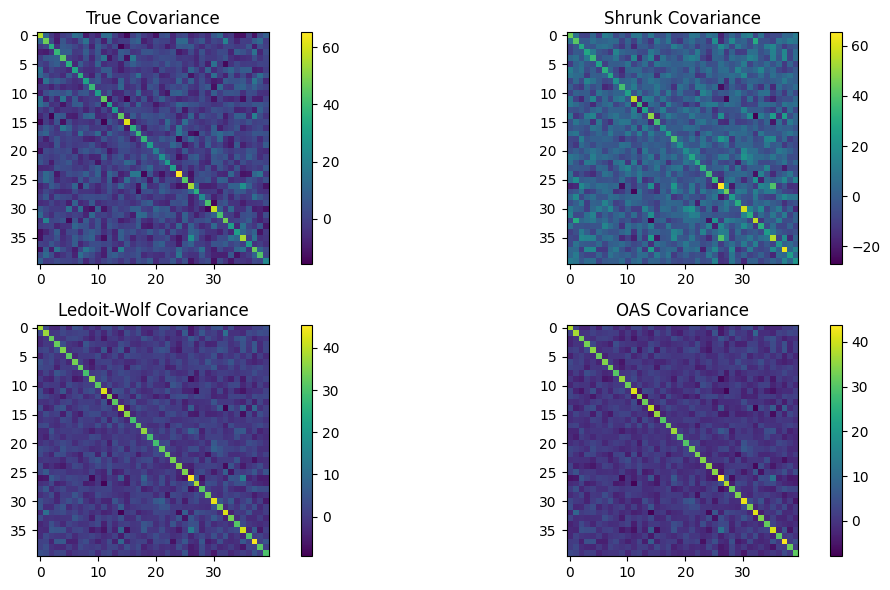

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)

# Plot results
plt.figure(figsize=(12, 6))

# Plot true covariance
plt.subplot(2, 2, 1)
plt.imshow(true_cov, cmap='viridis', interpolation='nearest')
plt.title('True Covariance')
plt.colorbar()
print("True Covariance:")
print(true_cov)

# Plot Shrunk Covariance
plt.subplot(2, 2, 2)
plt.imshow(shrunk_cov.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Shrunk Covariance')
plt.colorbar()
print("Shrunk Covariance:")
print(shrunk_cov.covariance_)

# Plot Ledoit-Wolf Covariance
plt.subplot(2, 2, 3)
plt.imshow(lw.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Ledoit-Wolf Covariance')
plt.colorbar()
print("Ledoit-Wolf Covariance:")
print(lw.covariance_)

# Plot OAS Covariance
plt.subplot(2, 2, 4)
plt.imshow(oa.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OAS Covariance')
plt.colorbar()
print("OAS Covariance:")
print(oa.covariance_)

plt.tight_layout()
plt.show()


In [14]:
import numpy as np
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)

# Calculate RMSE for each estimator
def rmse(estimator):
    estimated_cov = estimator.covariance_
    return np.sqrt(np.mean((true_cov - estimated_cov) ** 2))

rmse_shrunk_cov = rmse(shrunk_cov)
rmse_lw = rmse(lw)
rmse_oa = rmse(oa)

# Print RMSE for each estimator
print("RMSE of Shrunk Covariance:", rmse_shrunk_cov)
print("RMSE of Ledoit-Wolf Covariance:", rmse_lw)
print("RMSE of OAS Covariance:", rmse_oa)


RMSE of Shrunk Covariance: 6.973786251509533
RMSE of Ledoit-Wolf Covariance: 5.215613227627725
RMSE of OAS Covariance: 5.298396340703248


True Covariance:
[[ 55.98650342  10.78037447  -2.20052586 ... -11.80252269   1.88835878
    8.74131975]
 [ 10.78037447  47.38235643   1.41777213 ...   7.80899951  11.93443129
   -1.28672464]
 [ -2.20052586   1.41777213  35.06426316 ...  -9.23626087   3.77178661
   -0.3146597 ]
 ...
 [-11.80252269   7.80899951  -9.23626087 ...  46.81951921   9.72228333
    2.03238391]
 [  1.88835878  11.93443129   3.77178661 ...   9.72228333  43.0968695
    0.83461851]
 [  8.74131975  -1.28672464  -0.3146597  ...   2.03238391   0.83461851
   22.47597744]]
Shrunk Covariance:
[[ 44.83415459   7.7811139   -8.29053957 ...   3.67995136   3.21147403
   11.45340052]
 [  7.7811139   41.66909357  -1.1619159  ...   4.60414672  10.96417587
    8.6605628 ]
 [ -8.29053957  -1.1619159   29.01126628 ... -10.64880997  -4.11952508
   -1.89652291]
 ...
 [  3.67995136   4.60414672 -10.64880997 ...  63.55180808   2.74847418
   14.16160441]
 [  3.21147403  10.96417587  -4.11952508 ...   2.74847418  24.62226712
    2.4204743

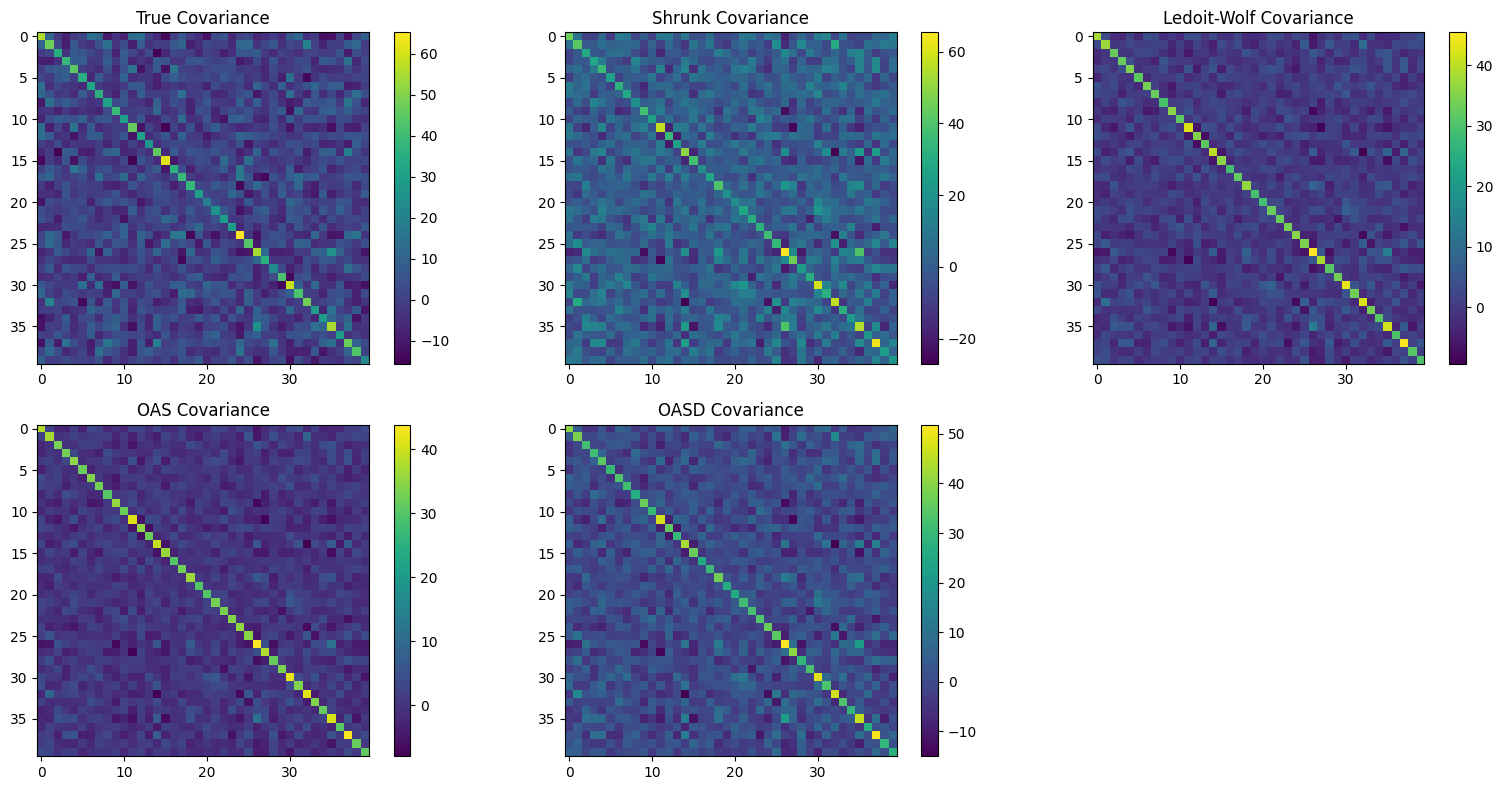

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Plot results
plt.figure(figsize=(16, 8))

# Plot true covariance
plt.subplot(2, 3, 1)
plt.imshow(true_cov, cmap='viridis', interpolation='nearest')
plt.title('True Covariance')
plt.colorbar()
print("True Covariance:")
print(true_cov)

# Plot Shrunk Covariance
plt.subplot(2, 3, 2)
plt.imshow(shrunk_cov.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Shrunk Covariance')
plt.colorbar()
print("Shrunk Covariance:")
print(shrunk_cov.covariance_)

# Plot Ledoit-Wolf Covariance
plt.subplot(2, 3, 3)
plt.imshow(lw.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Ledoit-Wolf Covariance')
plt.colorbar()
print("Ledoit-Wolf Covariance:")
print(lw.covariance_)

# Plot OAS Covariance
plt.subplot(2, 3, 4)
plt.imshow(oa.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OAS Covariance')
plt.colorbar()
print("OAS Covariance:")
print(oa.covariance_)

# Plot OASD Covariance
plt.subplot(2, 3, 5)
plt.imshow(oasd.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OASD Covariance')
plt.colorbar()
print("OASD Covariance:")
print(oasd.covariance_)

plt.tight_layout()
plt.show()


In [17]:
import numpy as np
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Calculate RMSE for each estimator
def rmse(estimator):
    estimated_cov = estimator.covariance_
    return np.sqrt(np.mean((true_cov - estimated_cov) ** 2))

rmse_shrunk_cov = rmse(shrunk_cov)
rmse_lw = rmse(lw)
rmse_oa = rmse(oa)
rmse_oasd = rmse(oasd)

# Print RMSE for each estimator
print("RMSE of Shrunk Covariance:", rmse_shrunk_cov)
print("RMSE of Ledoit-Wolf Covariance:", rmse_lw)
print("RMSE of OAS Covariance:", rmse_oa)
print("RMSE of OASD Covariance:", rmse_oasd)


RMSE of Shrunk Covariance: 6.973786251509533
RMSE of Ledoit-Wolf Covariance: 5.215613227627725
RMSE of OAS Covariance: 5.298396340703248
RMSE of OASD Covariance: 5.25197607403921


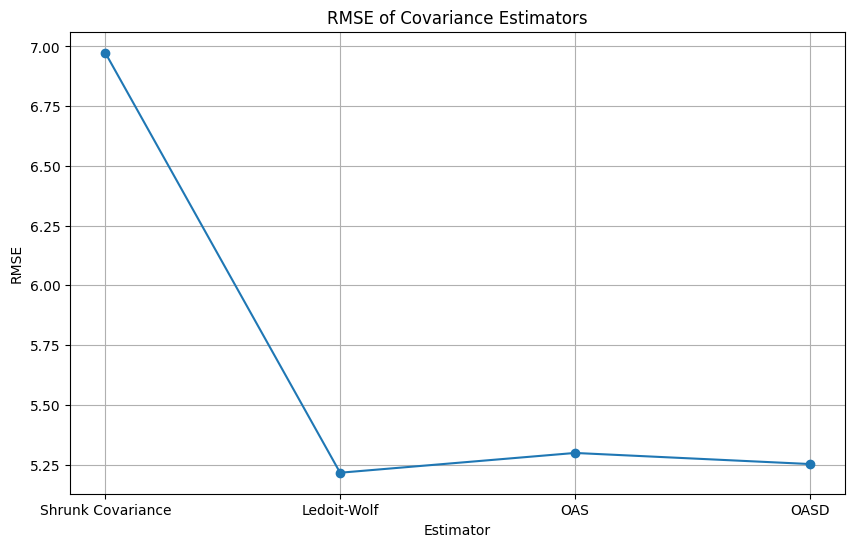

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Calculate RMSE for each estimator
def rmse(estimator):
    estimated_cov = estimator.covariance_
    return np.sqrt(np.mean((true_cov - estimated_cov) ** 2))

rmse_shrunk_cov = rmse(shrunk_cov)
rmse_lw = rmse(lw)
rmse_oa = rmse(oa)
rmse_oasd = rmse(oasd)

# Create a time series plot of RMSE values
estimators = ['Shrunk Covariance', 'Ledoit-Wolf', 'OAS', 'OASD']
rmse_values = [rmse_shrunk_cov, rmse_lw, rmse_oa, rmse_oasd]

plt.figure(figsize=(10, 6))
plt.plot(estimators, rmse_values, marker='o', linestyle='-')
plt.title('RMSE of Covariance Estimators')
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


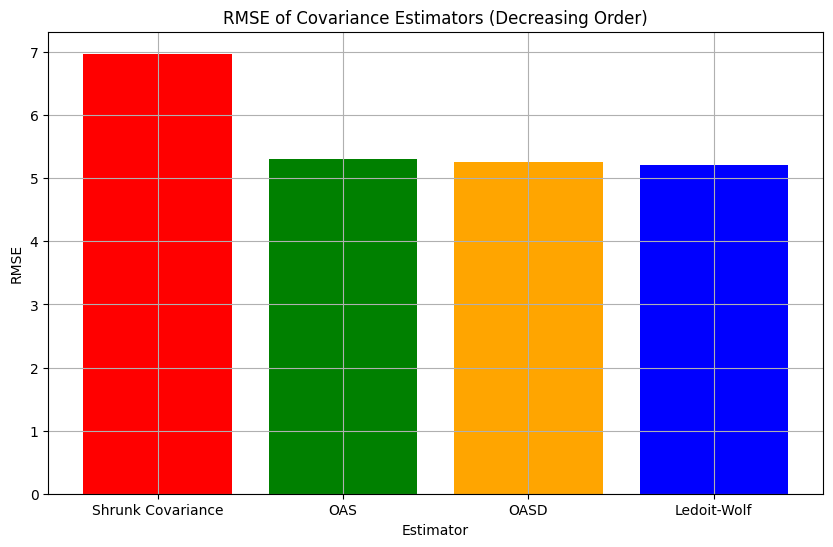

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Calculate RMSE for each estimator
def rmse(estimator):
    estimated_cov = estimator.covariance_
    return np.sqrt(np.mean((true_cov - estimated_cov) ** 2))

# Calculate RMSE for each estimator
rmse_shrunk_cov = rmse(shrunk_cov)
rmse_lw = rmse(lw)
rmse_oa = rmse(oa)
rmse_oasd = rmse(oasd)

# Create a time series plot of RMSE values in decreasing order
estimators = ['Shrunk Covariance', 'Ledoit-Wolf', 'OAS', 'OASD']
rmse_values = [rmse_shrunk_cov, rmse_lw, rmse_oa, rmse_oasd]
colors = ['red', 'blue', 'green', 'orange']

# Sort estimators and RMSE values in descending order of RMSE
estimators_sorted = [x for _, x in sorted(zip(rmse_values, estimators), reverse=True)]
rmse_values_sorted = sorted(rmse_values, reverse=True)
colors_sorted = [x for _, x in sorted(zip(rmse_values, colors), reverse=True)]

plt.figure(figsize=(10, 6))
plt.bar(estimators_sorted, rmse_values_sorted, color=colors_sorted)
plt.title('RMSE of Covariance Estimators (Decreasing Order)')
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


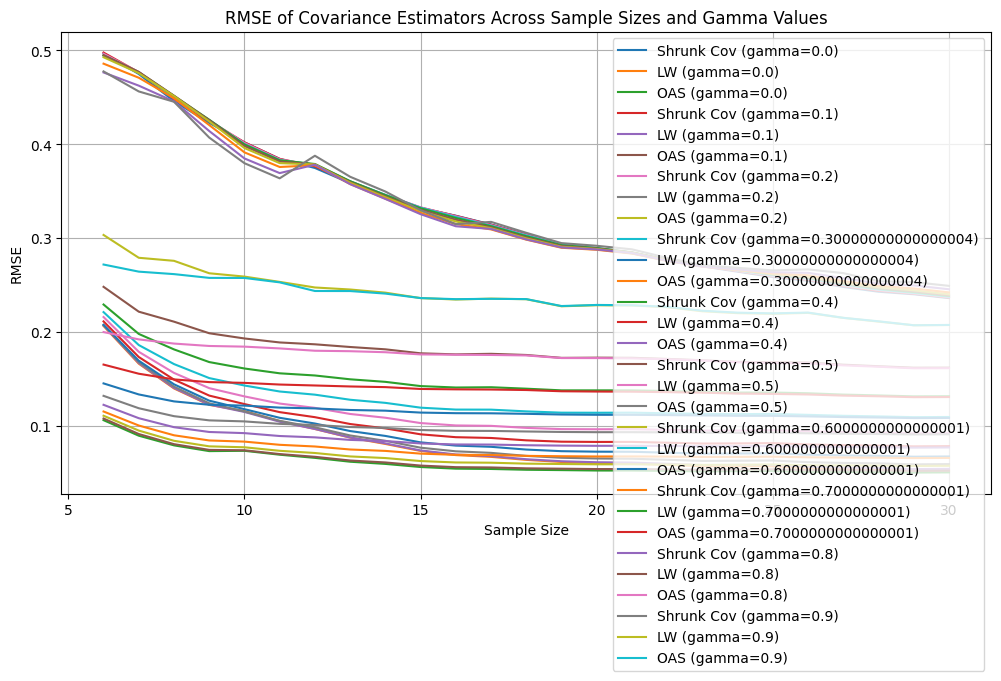

In [20]:
cc

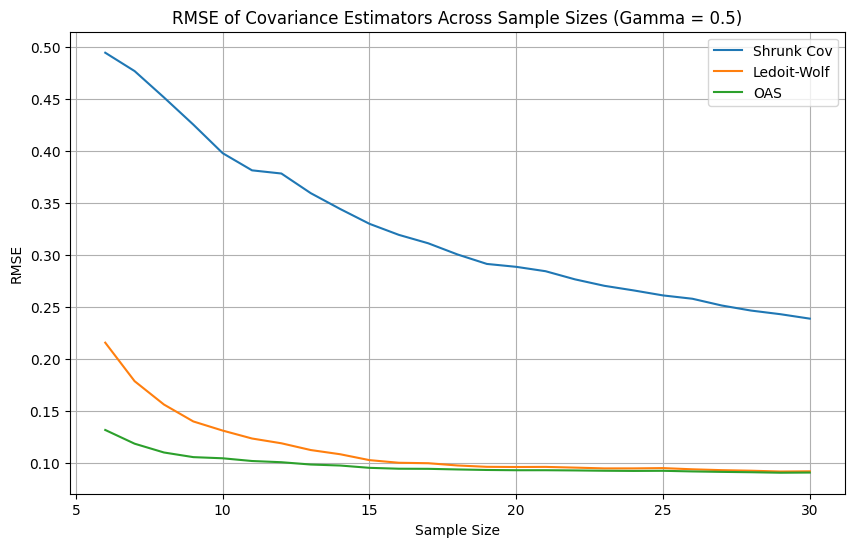

In [21]:
import numpy as np
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance
from sklearn.metrics import mean_squared_error

# Parameters
p = 100  # Dimensionality
n_values = np.arange(6, 31)  # Sample sizes from 6 to 30
gamma = 0.5  # Gamma value controlling sparsity

# Function to generate true covariance matrix Σ
def generate_true_covariance(p, gamma):
    # Create correlation matrix Γ with decaying off-diagonal elements
    Gamma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Gamma[i, j] = gamma ** np.abs(i - j)

    # Introduce different means for half of the variables
    means = np.zeros(p)
    means[p//2:] = 1

    # Create true covariance matrix Σ
    Sigma = Gamma + np.diag(means)
    return Sigma

# Generate and fit covariance estimators for different sample sizes
results = []
for n in n_values:
    row = {'n': n}

    # Generate true covariance matrix
    true_covariance = generate_true_covariance(p, gamma)

    # Generate sample data
    np.random.seed(42)
    X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=true_covariance, size=n)

    # Fit covariance estimators
    shrunk_cov = ShrunkCovariance().fit(X_train)
    lw = LedoitWolf().fit(X_train)
    oa = OAS().fit(X_train)

    # Calculate RMSE for each estimator
    rmse_shrunk_cov = mean_squared_error(true_covariance.ravel(), shrunk_cov.covariance_.ravel(), squared=False)
    rmse_lw = mean_squared_error(true_covariance.ravel(), lw.covariance_.ravel(), squared=False)
    rmse_oa = mean_squared_error(true_covariance.ravel(), oa.covariance_.ravel(), squared=False)

    # Store results
    row[f'Shrunk Cov'] = rmse_shrunk_cov
    row[f'LW'] = rmse_lw
    row[f'OAS'] = rmse_oa

    results.append(row)

# Convert results to DataFrame for visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
plt.plot(results_df['n'], results_df['Shrunk Cov'], label='Shrunk Cov')
plt.plot(results_df['n'], results_df['LW'], label='Ledoit-Wolf')
plt.plot(results_df['n'], results_df['OAS'], label='OAS')

plt.title('RMSE of Covariance Estimators Across Sample Sizes (Gamma = 0.5)')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


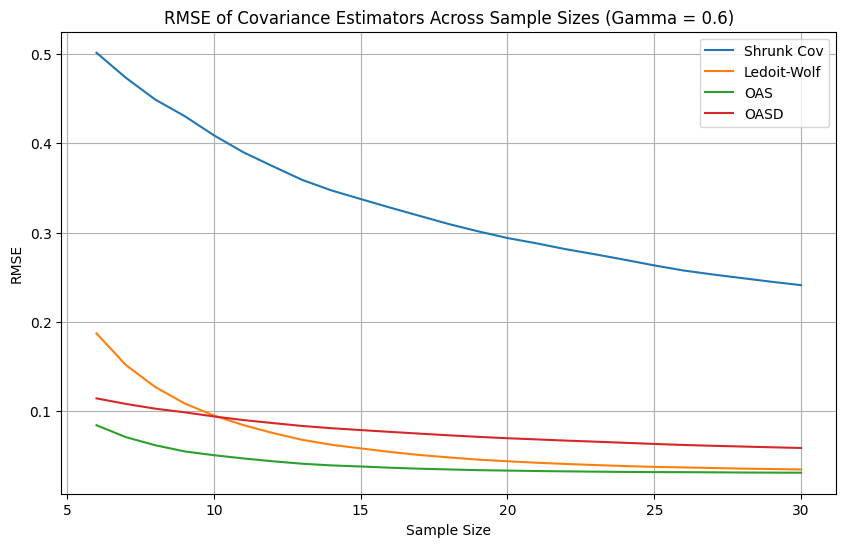

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance
from sklearn.metrics import mean_squared_error

# Parameters
p = 1000  # Dimensionality
n_values = np.arange(6, 31)  # Sample sizes from 6 to 30
gamma = 0.5  # Gamma value controlling sparsity

# Function to generate true covariance matrix Σ
def generate_true_covariance(p, gamma):
    # Create correlation matrix Γ with decaying off-diagonal elements
    Gamma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Gamma[i, j] = gamma ** np.abs(i - j)

    # Introduce different means for half of the variables
    means = np.zeros(p)
    means[p//2:] = 1

    # Create true covariance matrix Σ
    Sigma = Gamma + np.diag(means)
    return Sigma

# Generate and fit covariance estimators for different sample sizes
results = {'Shrunk Cov': [], 'Ledoit-Wolf': [], 'OAS': [], 'OASD': []}
for n in n_values:
    # Generate true covariance matrix
    true_covariance = generate_true_covariance(p, gamma)

    # Generate sample data
    np.random.seed(42)
    X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=true_covariance, size=n)

    # Fit covariance estimators
    shrunk_cov = ShrunkCovariance().fit(X_train)
    lw = LedoitWolf().fit(X_train)
    oa = OAS().fit(X_train)
    oasd = ShrunkCovariance(shrinkage=0.8).fit(X_train)  # OASD estimator

    # Calculate RMSE for each estimator
    rmse_shrunk_cov = mean_squared_error(true_covariance.ravel(), shrunk_cov.covariance_.ravel(), squared=False)
    rmse_lw = mean_squared_error(true_covariance.ravel(), lw.covariance_.ravel(), squared=False)
    rmse_oa = mean_squared_error(true_covariance.ravel(), oa.covariance_.ravel(), squared=False)
    rmse_oasd = mean_squared_error(true_covariance.ravel(), oasd.covariance_.ravel(), squared=False)

    # Store RMSE values
    results['Shrunk Cov'].append(rmse_shrunk_cov)
    results['Ledoit-Wolf'].append(rmse_lw)
    results['OAS'].append(rmse_oa)
    results['OASD'].append(rmse_oasd)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator, rmse_values in results.items():
    plt.plot(n_values, rmse_values, label=estimator)

plt.title('RMSE of Covariance Estimators Across Sample Sizes (Gamma = 0.6)')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


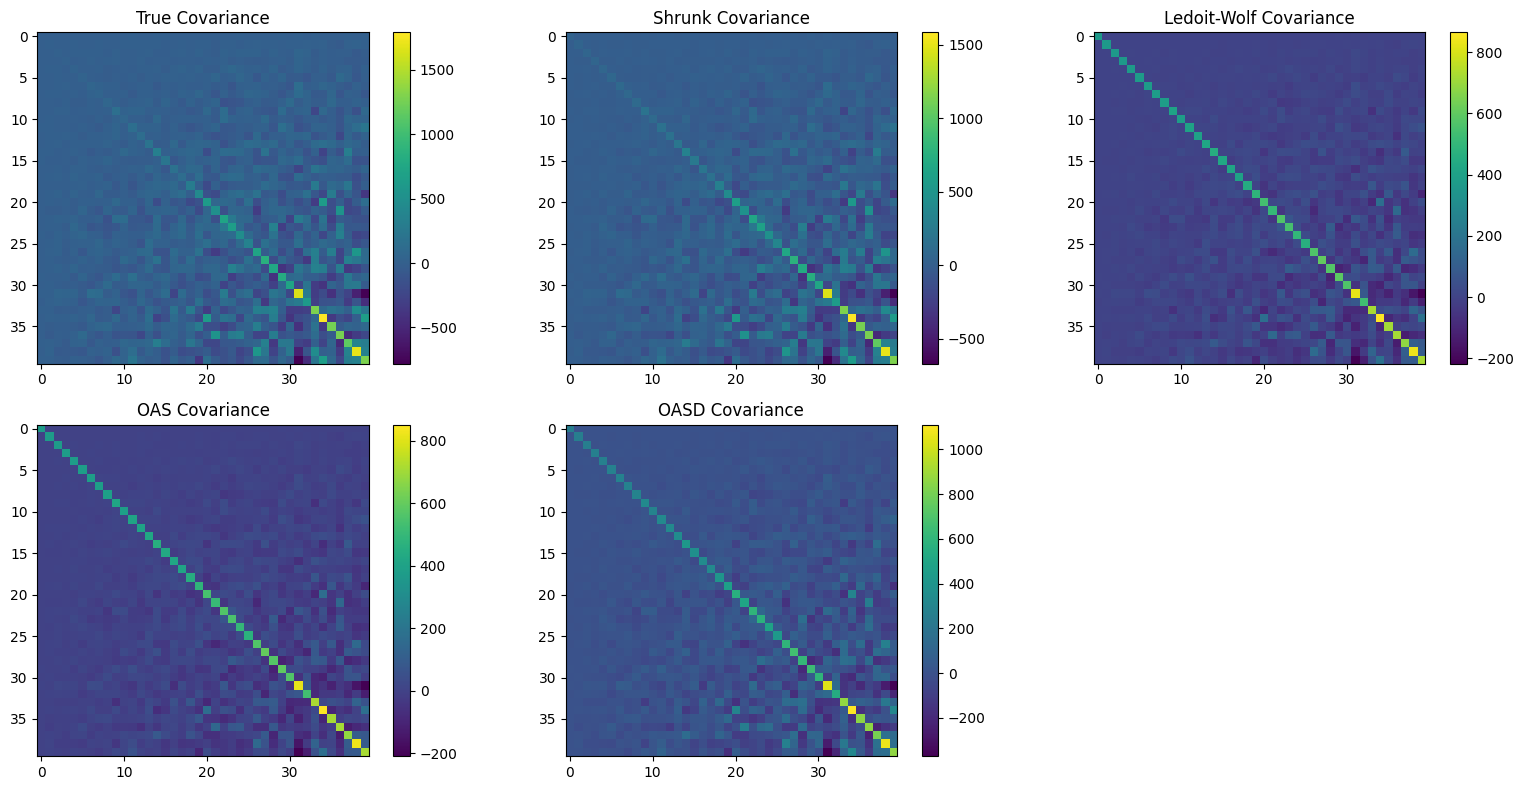

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Parameters
n_features, n_samples = 40, 20

# Generate sample data with different variable scales
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Define scaling factors for each variable
scaling_factors = np.arange(1, n_features + 1)

# Apply scaling factors to each variable
X_train = base_X_train * scaling_factors
X_test = base_X_test * scaling_factors

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Compute the true covariance (not taking into account variable scales)
true_cov = np.cov(X_train, rowvar=False)

# Plot results
plt.figure(figsize=(16, 8))

# Plot true covariance
plt.subplot(2, 3, 1)
plt.imshow(true_cov, cmap='viridis', interpolation='nearest')
plt.title('True Covariance')
plt.colorbar()

# Plot Shrunk Covariance
plt.subplot(2, 3, 2)
plt.imshow(shrunk_cov.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Shrunk Covariance')
plt.colorbar()

# Plot Ledoit-Wolf Covariance
plt.subplot(2, 3, 3)
plt.imshow(lw.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Ledoit-Wolf Covariance')
plt.colorbar()

# Plot OAS Covariance
plt.subplot(2, 3, 4)
plt.imshow(oa.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OAS Covariance')
plt.colorbar()

# Plot OASD Covariance
plt.subplot(2, 3, 5)
plt.imshow(oasd.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OASD Covariance')
plt.colorbar()

plt.tight_layout()
plt.show()


RMSE values:
Shrunk Covariance: [63.79915113385546, 52.75847540496442, 54.07840159743313, 46.96835707405778, 35.36831963796972, 35.143229912452625, 30.70054712035539, 30.819599329836322, 31.30948922499453, 30.933366826027576, 25.853663272620306, 26.691963715961148, 21.989032284440327, 21.422382912978026, 20.610430505316952, 22.224058005794074, 21.644335473177208, 20.271149012004404, 20.033701975313978, 18.18247619035053, 19.32149897991137, 18.804069293804474, 19.19438307915483, 19.806580274321618, 19.15058329292626]
Ledoit-Wolf: [158.1425576354704, 157.69203873972066, 173.308106145772, 164.07635761694578, 143.2769854817283, 144.5882403090296, 115.91595319434855, 122.25796524115421, 124.85735471897142, 129.78310845812263, 121.54766323398297, 127.50040509347924, 104.27799969902456, 92.86445824799969, 92.67822336323796, 103.56826955273411, 104.2937584774657, 90.45645690626503, 98.31190462215825, 89.53540587181679, 88.37993838137025, 96.31435942394663, 79.71209729112007, 90.105214515269, 8

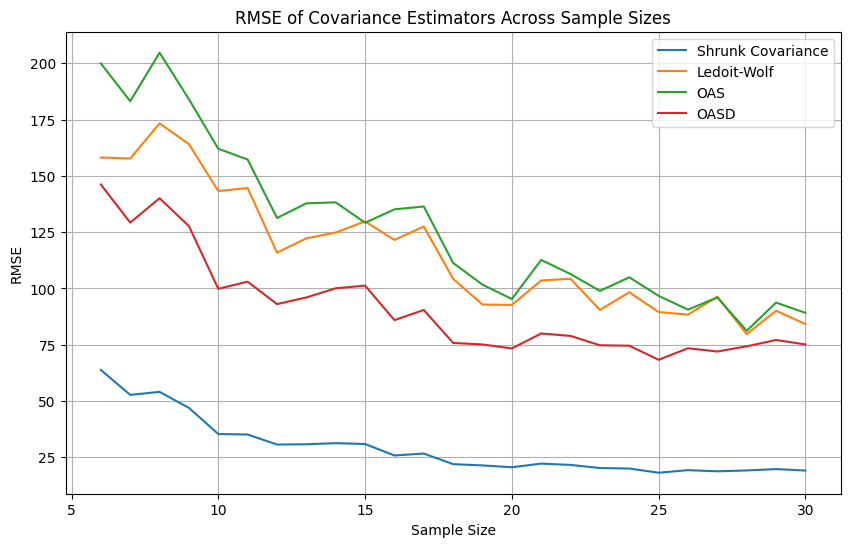

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 31)  # Sample sizes from 6 to 30

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Shrunk Covariance': [], 'Ledoit-Wolf': [], 'OAS': [], 'OASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Shrunk Covariance', ShrunkCovariance()),
                                      ('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


RMSE values:
Shrunk Covariance: [80.38109619819565, 61.944714072198046, 52.206957301601, 54.60158280715999, 40.24955119434427, 32.10259690384597, 30.581982296790116, 32.25132202279763, 31.62129598501707, 27.167050579483462, 25.986616921139802, 23.649915171231783, 26.621038608745884, 23.32464550373957, 21.834441514625624, 20.753479802729835, 20.007841247268864, 18.0274464543929, 18.457124244753274, 16.862815157446278, 16.87675071455698, 19.264750660512714, 15.67319115366465, 19.79549955151878, 17.58228366394283]
Ledoit-Wolf: [195.79261382407444, 190.45228651603344, 177.1752678839317, 184.59153436285933, 157.58929880383982, 130.51401663092182, 125.00354677639032, 137.87895221660196, 130.54119622529262, 133.49427259542026, 116.17563340048541, 115.13609782680635, 114.49221012849054, 104.31802842995498, 105.3970134860686, 104.95116852669129, 99.18971506205025, 96.80543021011212, 95.8368193949379, 84.7133099237748, 79.96537342427587, 90.08742493128427, 81.02112114943047, 84.3166926209351, 75

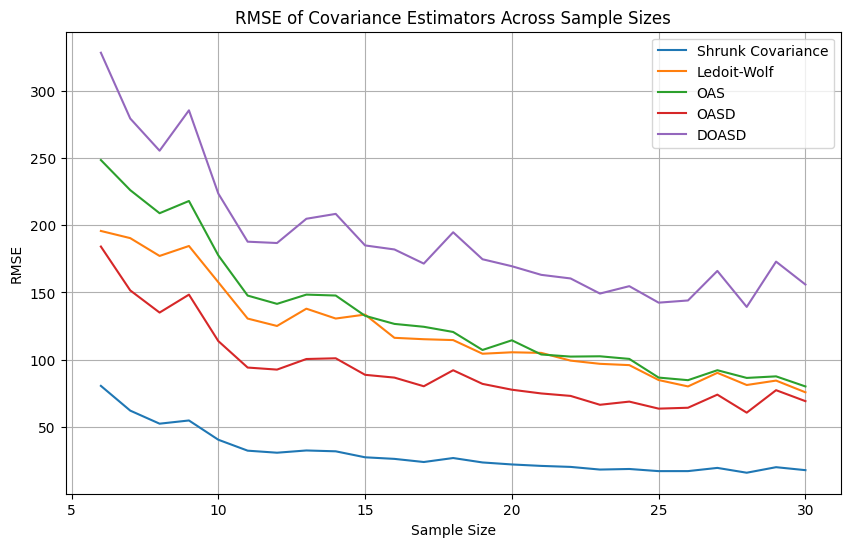

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 31)  # Sample sizes from 6 to 30

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):

        # Compute shrinkage targets
        trace_emp_cov = np.trace(emp_cov)
        diag_target = trace_emp_cov / n_features
        off_diag_target = 0.0  # For simplicity, off-diagonal target is set to 0

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Shrunk Covariance': [], 'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Shrunk Covariance', ShrunkCovariance()),
                                      ('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


RMSE values:
Shrunk Covariance: [68.62783487367038, 68.46904180757646, 47.68577218847862, 41.94078514764629, 37.670484455525084, 34.773672941604126, 36.790518423154516, 29.836311275955342, 30.777676385450594, 29.24904080026225, 26.557992723586974, 25.00058368713524, 22.51964919976086, 21.40525398792685, 22.799331788966654, 21.865714350714306, 19.905467521499613, 18.486050077760094, 20.85023682822628, 17.95121025476522, 17.482309969642227, 16.801646841673026, 16.697463778732008, 16.48481586553788, 18.633062736899415]
Ledoit-Wolf: [175.87954920126666, 204.86802063837345, 143.87712423801477, 143.65395781498546, 146.64270647968254, 146.59625675562793, 152.37400930555125, 119.41255101369417, 131.22339270636624, 124.94591235282934, 105.46662752484691, 107.89778677458261, 104.43844971887773, 104.46025562341636, 110.21849834995103, 101.926434530434, 91.52981487482792, 95.65690137921992, 101.00384363544873, 88.4781579141581, 83.95580888219759, 88.14563152927948, 83.46685010699183, 83.1397665018

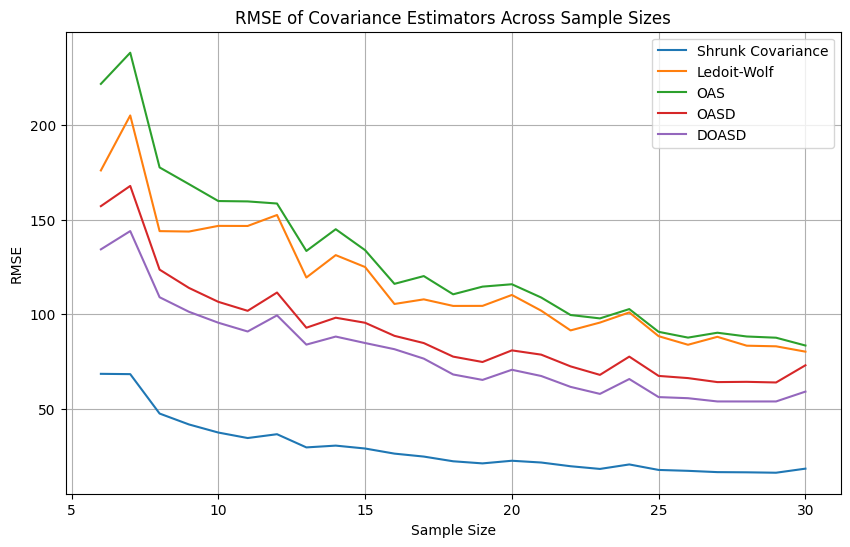

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 31)  # Sample sizes from 6 to 30

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Shrunk Covariance': [], 'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Shrunk Covariance', ShrunkCovariance()),
                                      ('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
